<a href="https://colab.research.google.com/github/sairampolina/Image-Stitching-From-Scratch/blob/master/Image_Stitching_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


## Download data

In [2]:
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 47.1MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     


## Helper Functions

In [10]:
from numpy.core.fromnumeric import searchsorted

# Defining own helper functions

def getMatches(points1,points2,descriptors1,descriptors2):


  h=points1.shape[0]

  matchedPairs=np.zeros((h,4))
  
  # for each descriptor in point 1 calculate nearest neighbour ratio
  for i,descriptor in enumerate(descriptors1):

    SSDdistance=[]
    sortedList=[]

    for descriptor2 in descriptors2:

      SSDdistance.append(np.sum(np.square(descriptor-descriptor2)))

    sortedList=sorted(SSDdistance)

    nearestND=sortedList[0]

    nearestN1D=sortedList[1]

    nearestNPosition=SSDdistance.index(nearestND)

    # if nearest neighbour ratio is less than 0.05 , consider the pair as bestmatch
    if(nearestND/nearestN1D)<0.05:

      matchedPairs[i,0:2]=points1[i,:]
      matchedPairs[i,2:4]=points2[nearestNPosition,:]

  matchedPairs = matchedPairs[~np.all(matchedPairs == 0, axis=1)]
  
  return matchedPairs

def plotMatches(matchedPairs,image,ewidth):

  concat=image.copy()
 
  for row in matchedPairs:

    x1=int(row[0])
    y1=int(row[1])
    x2=int(row[2])
    y2=int(row[3])

    cv2.circle(concat,(x1,y1),3,(255,0,0))
    cv2.circle(concat,(x2+ewidth,y2),3,(0,0,255))

    cv2.line(concat,(x1,y1),(x2+ewidth,y2),(0,225,0),thickness=1)

  plt.figure(figsize=(15,15))

  plt.imshow(concat[:,:,::-1])
  plt.title("Corresponding Points")
  plt.axis("off")
  plt.show()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)
def getNormalizedPoints(Points):

  matchesHeight=Points.shape[0]
  # normalizing src Points
  srcVar=np.var(Points,axis=0)

  # Scaling Matrix
  srcU=np.array([[srcVar[0],0,0],[0,srcVar[1],0],[0,0,1]])

  # Zero-mean Matrix
  srcMean=np.mean(Points,axis=0)

  srcM=np.array([[1,0,-srcMean[0]],[0,1,-srcMean[1]],[0,0,1]])

  # Transformation matrix
  srcT=np.matmul(srcU,srcM)

  normalizedSrcPoints=np.zeros((matchesHeight,2))
  for i,point in enumerate(Points):
    srcPoint=np.array([point[0],point[1],1])

    normalizedSrcPoint=np.matmul(srcT,srcPoint)

    normalizedSrcPoints[i,:]=normalizedSrcPoint[0:2]

  return (normalizedSrcPoints,srcT)

def getBestH(matchedPairs):
  # finding normalized Points
  matchesHeight=matchedPairs.shape[0]
  desPoints=matchedPairs[:,0:2]
  srcPoints=matchedPairs[:,2:4]


  normalizedSrcPoints,srcT=getNormalizedPoints(srcPoints)

  normalizedDesPoints,desT=getNormalizedPoints(desPoints)
  hypothesisSet=[]
  count=0
  while(count!=100):

    # sample 4 random Matched Pairs
    randomIndices=np.random.randint(0,matchesHeight,size=4)

    # Compute HTilde
    HTilde=est_homography(normalizedSrcPoints[randomIndices,:],normalizedDesPoints[randomIndices,:])

    # Denormalizing HTilde to find H
    temp=np.matmul(HTilde,srcT)

    H=np.matmul(np.linalg.inv(desT),temp)

    # Verify the hypothesis H using RANSAC
    # count no of inliers
    inliers=0
    for point in matchedPairs:
      srcPoint=np.array([point[2],point[3],1])
      desPoint=np.array([point[0],point[1],1])
      apprxPointHomogenous=np.matmul(H,srcPoint)
      apprxPoint=apprxPointHomogenous/apprxPointHomogenous[2]
      d=np.linalg.norm(desPoint-apprxPoint)

      if d*d<1:
        inliers=inliers+1
    
    hypothesisSet.append([inliers,H])
    count+=1

  bestHypothesisSet=max(hypothesisSet,key=lambda x:x[0]) 

  bestH=bestHypothesisSet[1]

  return bestH

def getStitchedImage(image1,image2,image1Keypoints,image2Keypoints,descriptors1,descriptors2,concatenatedImage):

  # *************stitching image1 and image2*************
  # finding the Corresponding Points
  matchedPairs=getMatches(image1Keypoints,image2Keypoints,descriptors1,descriptors2)

  # Plotting Matches
  plotMatches(matchedPairs,concatenatedImage,image1.shape[1])

  # get best Homography matrix
  bestH=getBestH(matchedPairs)

  stitch1Width=image2.shape[1]+image1.shape[1]
  stitch1Height=image2.shape[0]

  stitch1= cv2.warpPerspective(image2, bestH, (stitch1Width, stitch1Height))

  

  stitch1[0:image1.shape[0],0:image1.shape[1]]=image1



  return (stitch1,bestH)

## Image Stitching pipeline

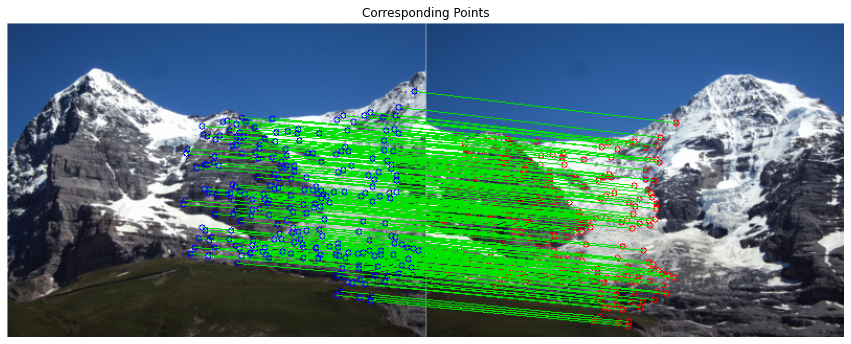

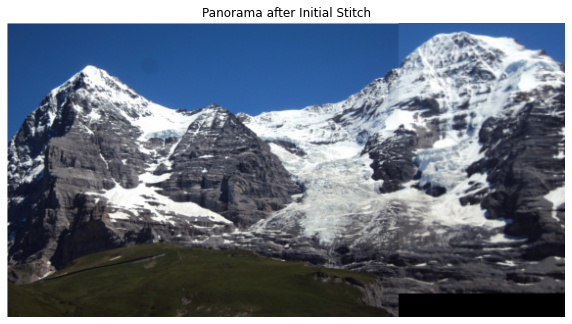

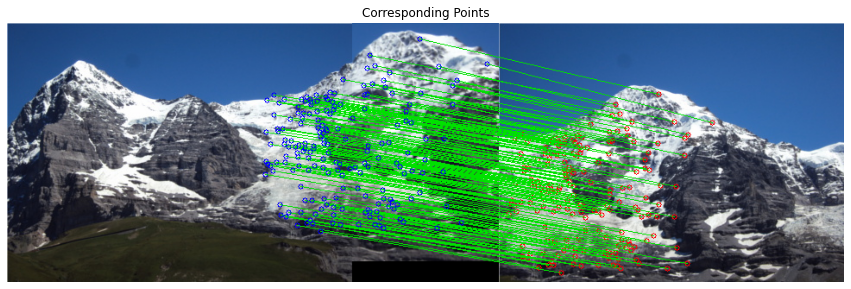

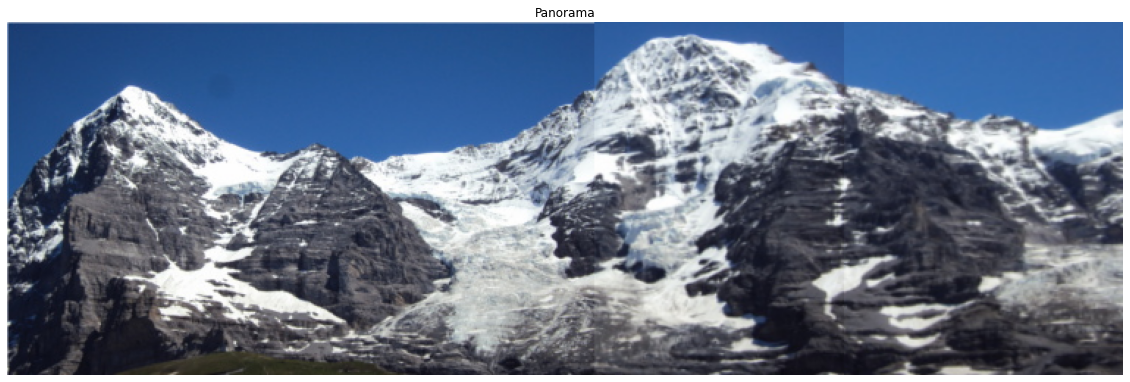

In [11]:
# reading the images
image1=cv2.imread('/content/hill/1.JPG')
image2=cv2.imread('/content/hill/2.JPG')
image3=cv2.imread('/content/hill/3.JPG')
concat12=np.hstack((image1,image2))

# get gray images
grayIm1=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
grayIm2=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
grayIm3=cv2.cvtColor(image3,cv2.COLOR_BGR2GRAY)


# SIFT detection
sift=cv2.SIFT_create()

kp1,descriptors1=sift.detectAndCompute(grayIm1,None)

kp2,descriptors2=sift.detectAndCompute(grayIm2,None)

kp3,descriptors3=sift.detectAndCompute(grayIm3,None)



# Processing keypoints to an array
n1=len(kp1)
image1Keypoints=np.ones((n1,2))
for i,point in enumerate(kp1):
  image1Keypoints[i,0]=point.pt[0]
  image1Keypoints[i,1]=point.pt[1]

n2=len(kp2)
image2Keypoints=np.ones((n2,2))
for i,point in enumerate(kp2):
  image2Keypoints[i,0]=point.pt[0]
  image2Keypoints[i,1]=point.pt[1]


n3=len(kp3)
image3Keypoints=np.ones((n3,2))
for i,point in enumerate(kp3):
  image3Keypoints[i,0]=point.pt[0]
  image3Keypoints[i,1]=point.pt[1]


# initial stitch
stitchedImage,bestHomography=getStitchedImage(image1,image2,image1Keypoints,image2Keypoints,descriptors1,descriptors2,concat12)

stitchedImage=stitchedImage[:,0:570]
plt.figure(figsize=(10,10))
plt.imshow(stitchedImage[:,:,::-1])
plt.title("Panorama after Initial Stitch")
plt.axis("off")
plt.show()



# get keypoints and Descriptors of Stitch1

grayStitchedImage=cv2.cvtColor(stitchedImage,cv2.COLOR_BGR2GRAY)
kp4,stitch1Descriptors=sift.detectAndCompute(grayStitchedImage,None)

n4=len(kp4)
stitch1Keypoints=np.ones((n4,2))
for i,point in enumerate(kp4):
  stitch1Keypoints[i,0]=point.pt[0]
  stitch1Keypoints[i,1]=point.pt[1]

concat13=np.hstack((stitchedImage,image3))


# Final Panorama 
Panorama,bestHomography1=getStitchedImage(stitchedImage,image3,stitch1Keypoints,image3Keypoints,stitch1Descriptors,descriptors3,concat13)
Panorama=Panorama[0:240,0:760]
plt.figure(figsize=(20,20))
plt.imshow(Panorama[:,:,::-1])
plt.title("Panorama")
plt.axis("off")
plt.show()


